# Volatility Scan Analysis

This notebook analyzes the results from the volatility scanner to identify optimal trading candidates with high volatility and low spread.
We filter for symbols with:
1. Spread% < 0.15% (and > 0%)
2. Avg Volume in the top 60% (>= 40th percentile)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## Load Data

Find the latest volatility scan CSV file.

In [2]:
# Find latest scan file
list_of_files = glob.glob('volatility_scan_*.csv') 
if not list_of_files:
    print("No scan files found.")
else:
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"Loading: {latest_file}")
    
    df = pd.read_csv(latest_file)
    # Ensure Avg Volume exists, if not compatible with old scans fill with 0
    if 'Avg Volume' not in df.columns:
        df['Avg Volume'] = 0
        
    print(f"Total symbols: {len(df)}")
    display(df.head())

Loading: volatility_scan_20260216_193234.csv
Total symbols: 945


,Symbol,Volatility%,Price,Spread,Spread%,Avg Volume,Min Vol,Vol Step,Contract,Path
0,MBLY,7.1513,8.51,73,8.5781,6.0,0.1,0.1,1.0,Stocks\US\MBLY
1,BLCN,3.2133,22.54,96,4.2591,5.0,1.0,1.0,1.0,ETF\ETF-R\BLCN
2,TEVA,2.8563,33.86,218,6.4383,29.0,0.1,0.1,1.0,Stocks\US\TEVA
3,GRVY,1.6439,66.22,222,3.3525,2.0,0.1,0.1,1.0,Stocks\US\GRVY
4,EDU,1.5109,54.84,817,14.8979,3.0,0.1,0.1,1.0,Stocks\US\EDU


## Data Overview

In [3]:
df.describe()

,Volatility%,Price,Spread,Spread%,Avg Volume,Min Vol,Vol Step,Contract
count,945.000000,9.450000e+02,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,0.202895,1.373339e+04,213.293122,0.500390,57.247619,0.359143,0.359143,7744.689947
std,0.296750,3.411312e+05,885.708905,1.496967,106.641358,0.423520,0.423520,26128.185185
min,0.000000,2.400000e-03,1.000000,0.001400,2.000000,0.010000,0.010000,1.000000
25%,0.114700,2.639000e+01,10.000000,0.053400,13.000000,0.100000,0.100000,1.000000
50%,0.168300,9.030000e+01,22.000000,0.128100,24.000000,0.100000,0.100000,1.000000
75%,0.239100,2.798500e+02,83.000000,0.251000,47.000000,1.000000,1.000000,10.000000
max,7.151300,1.045322e+07,16000.000000,16.666700,1051.000000,1.000000,1.000000,112000.000000


## Exploratory Data Analysis

Let's look at the distribution of Volatility and Spread.

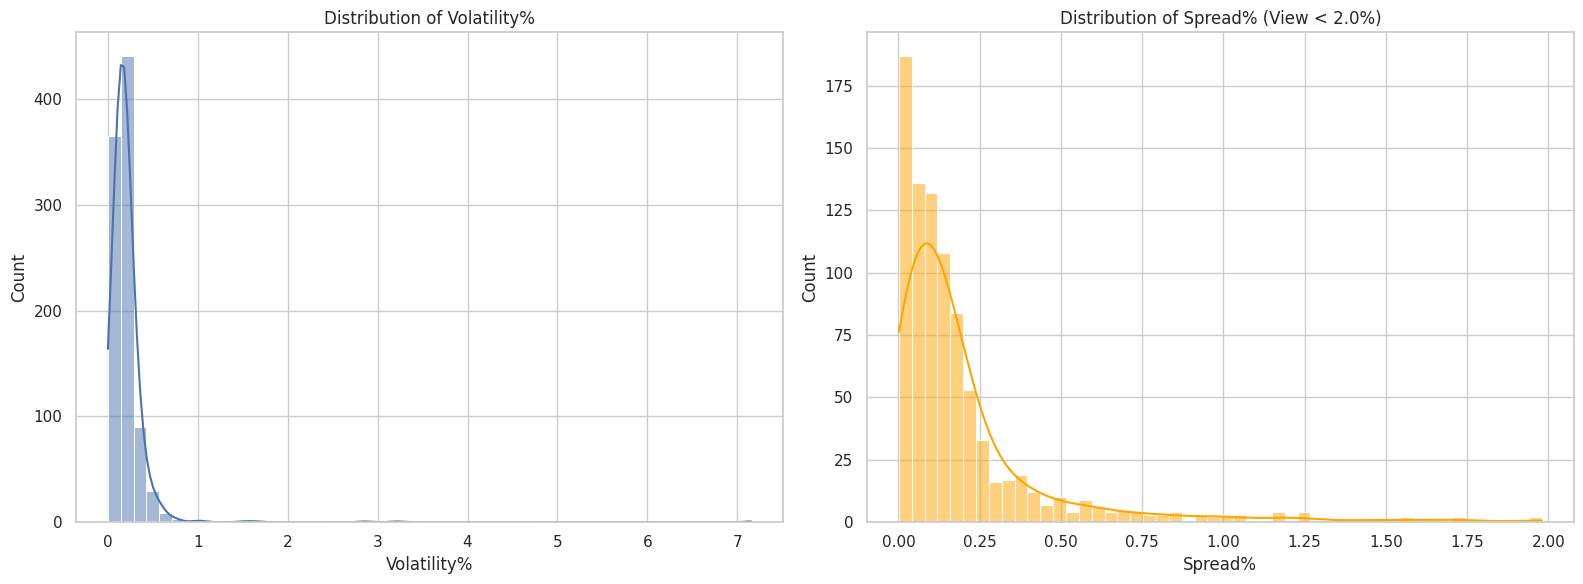

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Volatility Distribution
sns.histplot(data=df, x='Volatility%', bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Volatility%')

# Spread Distribution (filtering outliers for better view)
spread_view = df[df['Spread%'] < 2.0]  # Filter extreme spreads for visualization
sns.histplot(data=spread_view, x='Spread%', bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Distribution of Spread% (View < 2.0%)')

plt.tight_layout()
plt.show()

## Volume Analysis

Analyze the volume distribution to filter out illiquid symbols.
We will filter for the top 45% of symbols by volume (>= 55th percentile).

Volatility Cutoff (Top 45%): >= 0.1788%
Spread Cutoff (Bottom 45%): <= 0.1136%
Volume Cutoff (Top 45%): >= 26


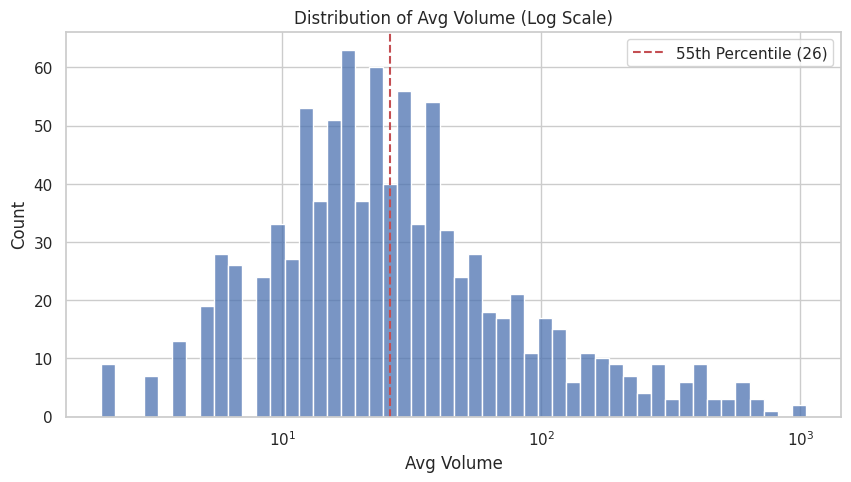

In [5]:
# Calculate Thresholds
vol_cutoff = df['Volatility%'].quantile(0.55)
spread_cutoff = df['Spread%'].quantile(0.45)
volume_cutoff = df['Avg Volume'].quantile(0.55)

print(f"Volatility Cutoff (Top 45%): >= {vol_cutoff:.4f}%")
print(f"Spread Cutoff (Bottom 45%): <= {spread_cutoff:.4f}%")
print(f"Volume Cutoff (Top 45%): >= {volume_cutoff:.0f}")

plt.figure(figsize=(10, 5))
# Filter extreme volume outliers for better visualization if needed
sns.histplot(data=df, x='Avg Volume', bins=50, log_scale=True, kde=False)
plt.axvline(x=volume_cutoff, color='r', linestyle='--', label=f'55th Percentile ({volume_cutoff:.0f})')
plt.title('Distribution of Avg Volume (Log Scale)')
plt.legend()
plt.show()

### Volatility vs Spread Scatter Plot

Ideally, we want symbols in the **top-left corner** (High Volatility, Low Spread).
We color code by Volume to see liquidity.

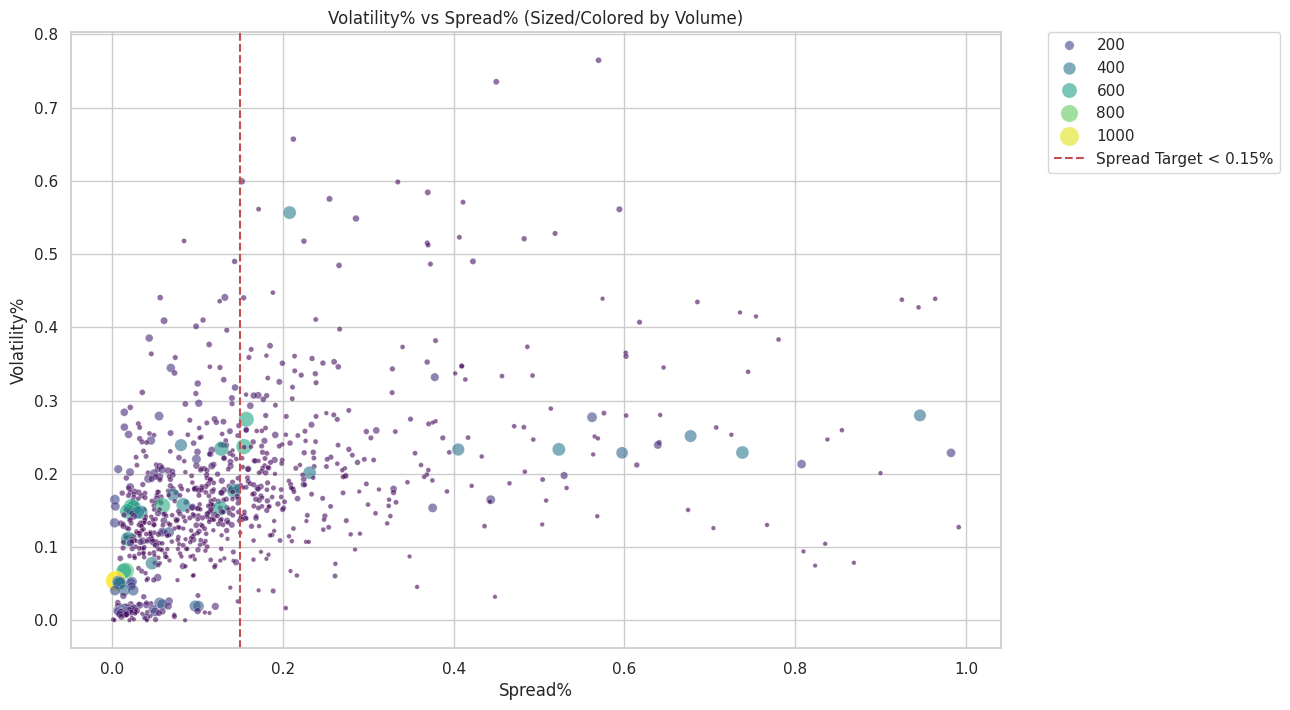

In [6]:
plt.figure(figsize=(12, 8))
# Filter for better visualization focus
plot_df = df[(df['Spread%'] < 1.0) & (df['Volatility%'] < 5.0)]

sns.scatterplot(
    data=plot_df, 
    x='Spread%', 
    y='Volatility%', 
    hue='Avg Volume',
    size='Avg Volume',
    sizes=(10, 200),
    alpha=0.6,
    palette='viridis'
)

plt.title('Volatility% vs Spread% (Sized/Colored by Volume)')
plt.axvline(x=0.15, color='r', linestyle='--', label='Spread Target < 0.15%')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Filter Candidates

We apply the intersection of the "Best 45%" for each metric to find the **Sweet Spot**:
1. **Volatility%**: Top 45% (>= 55th percentile)
2. **Spread%**: Bottom 45% (<= 45th percentile)
3. **Avg Volume**: Top 45% (>= 55th percentile)

In [9]:
# Apply Filters
candidates = df[
    (df['Volatility%'] >= vol_cutoff) &
    (df['Spread%'] <= spread_cutoff) &
    (df['Avg Volume'] >= volume_cutoff)
].copy()

# --- Filter Analysis ---
print(f"--- Filter Efficiency Analysis ---")
print(f"Total Symbols: {len(df)}")

pass_vol = len(df[df['Volatility%'] >= vol_cutoff])
pass_spread = len(df[df['Spread%'] <= spread_cutoff])
pass_volume = len(df[df['Avg Volume'] >= volume_cutoff])

print(f"Pass Volatility (>= {vol_cutoff:.4f}%): {pass_vol} ({pass_vol/len(df):.1%})")
print(f"Pass Spread     (<= {spread_cutoff:.4f}%): {pass_spread} ({pass_spread/len(df):.1%})")
print(f"Pass Volume     (>= {volume_cutoff:.0f}):   {pass_volume} ({pass_volume/len(df):.1%})")

# Calculate drops
print(f"Intersection (All 3): {len(candidates)} ({len(candidates)/len(df):.1%})")
print("-" * 30)

# Sort by Volatility
candidates = candidates.sort_values(by='Volatility%', ascending=False)

print(f"Found {len(candidates)} candidates in the 'Sweet Spot'.")

# Display Top 20
display_cols = ['Symbol', 'Volatility%', 'Spread%', 'Avg Volume', 'Price', 'Path']
display(candidates[display_cols].head(2000))

--- Filter Efficiency Analysis ---
Total Symbols: 945
Pass Volatility (>= 0.1788%): 425 (45.0%)
Pass Spread     (<= 0.1136%): 425 (45.0%)
Pass Volume     (>= 26):   446 (47.2%)
Intersection (All 3): 67 (7.1%)
------------------------------
Found 67 candidates in the 'Sweet Spot'.


,Symbol,Volatility%,Spread%,Avg Volume,Price,Path
41,AMAT,0.4405,0.0563,48.0,354.98,Stocks\US\AMAT
54,WDC,0.4099,0.1065,39.0,281.59,Stocks\US\WDC
55,MU,0.4090,0.0609,95.0,410.58,Stocks\US\MU
57,SHOP,0.4013,0.0984,56.0,111.79,Stocks\US\SHOP
63,FAZ,0.3853,0.0435,119.0,45.97,ETF\ETF-C\FAZ
...,...,...,...,...,...,...
411,SU,0.1807,0.0195,39.0,257.00,Stocks\EU\SU
416,ICE,0.1802,0.0988,42.0,151.84,Stocks\US\ICE
418,ALIBABA,0.1799,0.0969,52.0,154.86,Stocks\US\ALIBABA
419,CAT,0.1796,0.0712,38.0,772.55,Stocks\US\CAT


## Export Results

In [8]:
output_file = 'filtered_candidates.csv'
candidates.to_csv(output_file, index=False)
print(f"Saved {len(candidates)} candidates to {output_file}")

Saved 67 candidates to filtered_candidates.csv
